In [ ]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np

from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [ ]:
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [ ]:
##Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lower case
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [ ]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    
    return vocab

In [ ]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [ ]:
# all_train_captions = []
# for key, val in descriptions.items():
#     for cap in val:
#         all_train_captions.append(cap)

# # Consider only words which occur at least 8 times in the corpus
# word_count_threshold = 8
# word_counts = {}
# nsents = 0
# for sent in all_train_captions:
#     nsents += 1
#     for w in sent.split(' '):
#         word_counts[w] = word_counts.get(w, 0) + 1

# vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

# print('preprocessed words %d ' % len(vocab))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#dataset_text = "D:\dataflair projects\Project - Image Caption Generator\Flickr_8k_text"
dataset_text = "/content/drive/MyDrive/Deep Learning Project/Flickr8k_text"
#dataset_images = "D:\dataflair projects\Project - Image Caption Generator\Flicker8k_Dataset"
dataset_images ='/content/drive/MyDrive/Deep Learning Project/Flicker8k_Dataset'

In [ ]:
#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


In [ ]:

def extract_features(directory):
        model = InceptionV3( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            
            feature = model.predict(image)
            features[img] = feature
        return features

In [ ]:
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

87916544/87910968 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
features = load(open("features.p","rb"))


In [ ]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos):   
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        
        words = line.split()
        if len(words)<1 :
            continue
    
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


In [ ]:
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [ ]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary 

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer


In [ ]:
# give each word a index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size 

7577

In [ ]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

In [ ]:
features['1000268201_693b08cb0e.jpg'][0]

array([0.09671355, 0.2295712 , 0.76100296, ..., 0.41570735, 0.45861247,
       0.40678284], dtype=float32)

In [ ]:
# Define the model

#1 Photo feature extractor - we extracted features from pretrained model Xception. 
#2 Sequence processor - word embedding layer that handles text, followed by LSTM 
#3 Decoder - Both 1 and 2 model produce fixed length vector. They are merged together and processed by dense layer to make final prediction

In [ ]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ((input_image, input_sequence), output_word)        

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
(a,b),c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

In [ ]:
from keras.utils import plot_model


def define_model(vocab_size, max_length):
    
   
    inputscnn = Input(shape=(2048,))
    layer1 = Dropout(0.2)(inputscnn)
    layer2 = MaxPooling2D((3,3),strides=(2,2))(layer1)
    cnnlayer = Dense(256, activation='relu')(layer2)
    

  
    inputLstm = Input(shape=(max_length,))
    lstm1 = Embedding(vocab_size, 256, mask_zero=True)(inputLstm)
    lstm2 = Dropout(0.5)(lstm1)
    lstm3 = LSTM(256)(lstm2)

   
    decoderLayer1 = add([cnnlayer, lstm3])
    decoderLayer2 = Dense(256, activation='relu')(decoderLayer1)
    outputs = Dense(vocab_size, activation='softmax')(decoderLayer2)
    
   
    model = Model(inputs=(inputscnn, inputLstm), outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models_6")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models_6/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 32, 256)      1939712     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6000/6000 [==============================] - 1581s 264ms/step - loss: 2.8721


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt




start two dogs are playing with each other in the grass end


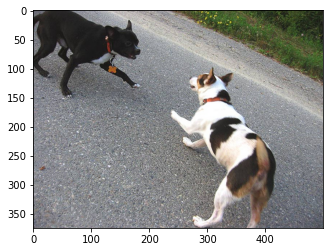

In [ ]:
img_path = "/content/drive/MyDrive/Deep Learning Project/Flicker8k_Dataset/1001773457_577c3a7d70.jpg"
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("/content/tokenizer.p","rb"))
model = load_model('/content/models_6/model_5.h5')
xception_model = InceptionV3(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [24]:
# Evaluation on test image:
reference_text = "A black dog and a spotted dog are fighting . A black dog and a tri-colored dog playing with each other on the road  .Two dogs of different breeds looking at each other on the road .Two dogs on pavement moving toward each other."

print(reference_text.split())

from nltk.translate.bleu_score import corpus_bleu
references = [[['A', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting'], [ 'A', 'black', 'dog', 'and', 'a', 'tri-colored', 'dog', 'playing', 'with', 'each', 'other', 'on', 'the', 'road']]]
candidates = [['two', 'dogs', 'are', 'playing', 'with', 'each', 'other','in','the','grass']]
score = corpus_bleu(references, candidates)
print(score)

['A', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting', '.', 'A', 'black', 'dog', 'and', 'a', 'tri-colored', 'dog', 'playing', 'with', 'each', 'other', 'on', 'the', 'road', '.Two', 'dogs', 'of', 'different', 'breeds', 'looking', 'at', 'each', 'other', 'on', 'the', 'road', '.Two', 'dogs', 'on', 'pavement', 'moving', 'toward', 'each', 'other.']
0.2907153684841096





start dog is running through the grass end


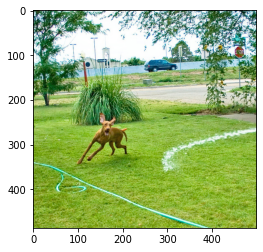

In [ ]:
img_path = "/content/drive/MyDrive/Deep Learning Project/Flicker8k_Dataset/1019077836_6fc9b15408.jpg"
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("/content/tokenizer.p","rb"))
model = load_model('/content/models_6/model_7.h5')
xception_model = InceptionV3(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [23]:
#Evaluation on above Image:
reference_text = "A brown dog chases the water from a sprinkler on a lawn . a brown dog plays with the hose .A dog is playing with a hose.Large brown dog running away from the sprinkler in the grass ."

print(reference_text.split())

from nltk.translate.bleu_score import corpus_bleu
references = [[['A', 'brown', 'dog', 'chases', 'the', 'water', 'from', 'a', 'sprinkler', 'on', 'a', 'lawn' ], ['a', 'brown', 'dog', 'plays', 'with', 'the', 'hose'],
               ['.A', 'dog', 'is', 'playing', 'with', 'a', 'hose.Large'],['brown', 'dog', 'running', 'away', 'from', 'the', 'sprinkler', 'in', 'the', 'grass',]]]
candidates = [['A', 'dog', 'is', 'running','through','the','grass']]
score = corpus_bleu(references, candidates)
print(score)


['A', 'brown', 'dog', 'chases', 'the', 'water', 'from', 'a', 'sprinkler', 'on', 'a', 'lawn', '.', 'a', 'brown', 'dog', 'plays', 'with', 'the', 'hose', '.A', 'dog', 'is', 'playing', 'with', 'a', 'hose.Large', 'brown', 'dog', 'running', 'away', 'from', 'the', 'sprinkler', 'in', 'the', 'grass', '.']
0.7311104457090247


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)





start two girls are playing on the beach end


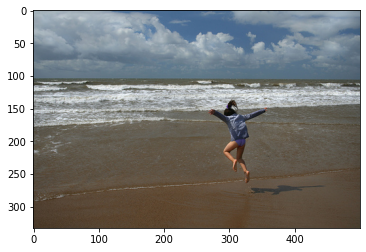

In [ ]:
img_path = "/content/drive/MyDrive/Deep Learning Project/Flicker8k_Dataset/1174525839_7c1e6cfa86.jpg"
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("/content/tokenizer.p","rb"))
model = load_model('/content/models_6/model_3.h5')
xception_model = InceptionV3(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [22]:
#Evaluation on above image
from nltk.translate.bleu_score import corpus_bleu
references = [[['A', 'girl', 'in', 'blue', 'is', 'jumping', 'on', 'the', 'shore'],['A', 'girl', 'leaps', 'into', 'the', 'air', 'while', 'standing', 'by', 'the', 'ocean'],
                ['.A', 'young', 'long-haired', 'girl', 'on', 'the', 'beach', 'is', 'jumping', 'in', 'the', 'air'],['The', 'girl', 'is', 'running', 'into', 'the', 'ocean', 'from', 'the', 'shore']
               ]]
candidates = [['two', 'girls', 'are', 'playing', 'on', 'the', 'beach']]
score = corpus_bleu(references, candidates)
print(score)

0.30895757752065417


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)





start dog is running through the grass end


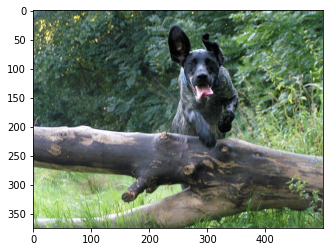

In [ ]:
img_path = "/content/drive/MyDrive/Deep Learning Project/Flicker8k_Dataset/1015584366_dfcec3c85a.jpg"
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("/content/tokenizer.p","rb"))
model = load_model('/content/models_6/model_8.h5')
xception_model = InceptionV3(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)




start man is sitting on the side of cliff overlooking the mountains end


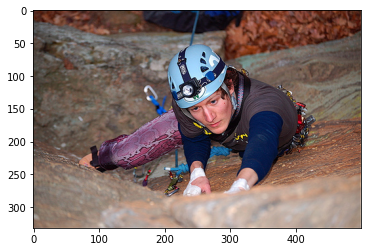

In [ ]:
img_path = "/content/drive/MyDrive/Deep Learning Project/Flicker8k_Dataset/111537222_07e56d5a30.jpg"
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("/content/tokenizer.p","rb"))
model = load_model('/content/models_6/model_5.h5')
xception_model = InceptionV3(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [2]:
reference_text = "A girl in blue is jumping on the shore as small waves approach her .A girl leaps into the air while standing by the ocean .A young long-haired girl on the beach is jumping in the air ,The girl is running into the ocean from the shore .The girls is jumping into the air on the beach"

print(reference_text.split())

['A', 'girl', 'in', 'blue', 'is', 'jumping', 'on', 'the', 'shore', 'as', 'small', 'waves', 'approach', 'her', '.A', 'girl', 'leaps', 'into', 'the', 'air', 'while', 'standing', 'by', 'the', 'ocean', '.A', 'young', 'long-haired', 'girl', 'on', 'the', 'beach', 'is', 'jumping', 'in', 'the', 'air', ',The', 'girl', 'is', 'running', 'into', 'the', 'ocean', 'from', 'the', 'shore', '.The', 'girls', 'is', 'jumping', 'into', 'the', 'air', 'on', 'the', 'beach']
